Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [4]:
!pip install icecream

  Obtaining dependency information for icecream from https://files.pythonhosted.org/packages/06/4e/21e309c7087695cf500a1827597f8510641f2c9a50ed7741bf7fc38736ff/icecream-2.1.3-py2.py3-none-any.whl.metadata


In [58]:
from random import random, seed
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
from icecream import ic

import math


## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [6]:
UNIVERSE_SIZE = 100_000 #Size of the universe here 100_000 different unit
NUM_SETS = 10_000
DENSITY = 0.3 #Probability of an element to be on a set (for each set)

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)])) #Here the size of each set is 10 000*0.3=3 333

In [7]:

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [8]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [24]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(True, 841061515.0106916)

In [177]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(True, 422717869.50755346)

## Problem modelization

I started by creating a class to modelize the problem. We have the intiale solution calculated randomly depending on the universe size, the number of sets, the list of sets and there costs.

Value allow to calculate the cost of a solution and is_valid allow to verify if a combinaison of sets is a solution to the problem.

Mutation function take the current solution and randomly add, delete or replace a set.

Neighbout create a new solution created from the current solution from which we applied Number of sets/10 sets. If the neighbour is valid then it is send back,if not we calculate an other one.

Once the problem created we can try different local search algorithm

In [96]:
class SetCoveringProblem:
    def __init__(self, universe_size, num_sets, sets, costs):
        self.universe_size = universe_size
        self.num_sets = num_sets
        self.sets = sets
        self.costs = costs
        self.initial = self.random_solution()

    def random_solution(self):
        return np.random.choice(self.num_sets, size=int(self.num_sets * DENSITY), replace=False)

    def value(self, solution):
        return cost(solution)
    
    def is_valid(self, solution):
        return valid(solution)

    def mutation(self, solution):
        new_solution = solution.copy()
        mutation=np.random.choice([0, 1, 2])
        
        if mutation==0:
            available_sets=list(set(range(self.num_sets))-set(new_solution))
            if available_sets:
                new_set=np.random.choice(available_sets)
                new_solution=np.append(new_solution,new_set)

        elif mutation == 1 and len(new_solution) > 1:
            remove_idx = np.random.randint(len(new_solution))
            new_solution = np.delete(new_solution, remove_idx)
            
        elif mutation == 2 and len(new_solution) > 1:
            remove_idx = np.random.randint(len(new_solution))
            available_sets = list(set(range(self.num_sets))-set(new_solution))
            if available_sets:
                new_set = np.random.choice(available_sets)
                new_solution[remove_idx] = new_set
        return new_solution
    
    def neighbour(self, solution):
        num_mutations = np.random.randint(1, self.num_sets // 10)  # Mutation of max 1/10 of the set (it can be less if some mutations inverse each others)
        new_solution = solution.copy()
        for _ in range(num_mutations):
            new_solution = self.mutation(new_solution)
        if not self.is_valid(new_solution):
            new_solution = self.neighbour(solution)
        return new_solution

## Simulated Anealling

In [100]:
def exponential_schedule(temperature=1000, alpha=0.95, limit=1000):#This function describe the evolution of the temperature
    return lambda t: (temperature * np.exp(-alpha * t) if t < limit else 1e-3)

def simulated_annealing(problem, max_iterations=1000, schedule=exponential_schedule(), max_evaluations=10000):
    # Initialisation de la solution
    current_solution = problem.random_solution()
    current_value = problem.value(current_solution)
    best_solution = current_solution
    best_value = current_value
    num_evaluations = 1
    costs = [current_value]
    temperature =schedule(0) #Initial temperature
    t=1

    while num_evaluations < max_evaluations and temperature >0:
        #Generate a Neighbour
        neighbour_solution=problem.neighbour(current_solution)
        neighbour_value=problem.value(neighbour_solution)
        num_evaluations+=1
        costs.append(neighbour_value)

        #If the neighbour is better we keep him
        if neighbour_value<current_value:
            current_solution=neighbour_solution
            current_value=neighbour_value
            if current_value<best_value:
                best_solution = current_solution
                best_value = current_value
                #print(best_value,problem.is_valid(best_solution))
        else:
            #If the neighbour is not better we calculate the probability to keep it using the temperature
            probability = math.exp((current_value-neighbour_value)/temperature)
            if random.random()<probability:
                current_solution=neighbour_solution
                current_value=neighbour_value

        #We calculate the temperature (cooling it down)
        temperature=schedule(t)
        t+=1# Increment time step

    return best_solution, best_value, num_evaluations, costs


In [101]:
#alpha=0.95
problem = SetCoveringProblem(UNIVERSE_SIZE, NUM_SETS, SETS, COSTS)
best_solution, best_value,evaluations, fit_list,  = simulated_annealing(problem)
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

C:\Users\user\AppData\Local\Temp\ipykernel_60456\1407305470.py:33: RuntimeWarning: overflow encountered in scalar divide
  probability = math.exp((current_value-neighbour_value) / temperature)


Best solution found has cost: 2519282.169588054
Number of evaluations: 785


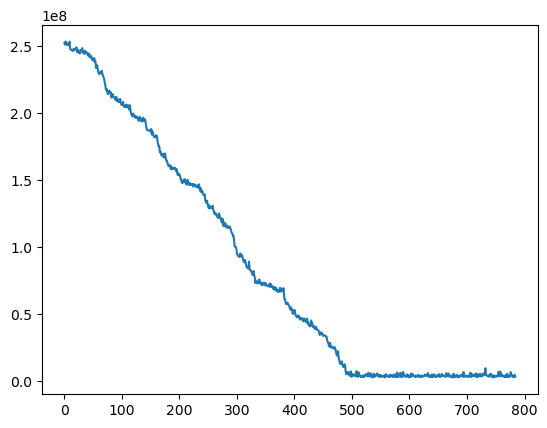

In [102]:
plt.plot(fit_list)

In [185]:
#temperature=10_000
problem = SetCoveringProblem(UNIVERSE_SIZE, NUM_SETS, SETS, COSTS)
best_solution, best_value,evaluations, fit_list,  = simulated_annealing(problem=problem,schedule=exponential_schedule(temperature=10_000))
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

C:\Users\user\AppData\Local\Temp\ipykernel_60456\1407305470.py:33: RuntimeWarning: overflow encountered in scalar divide
  probability = math.exp((current_value-neighbour_value) / temperature)


Best solution found has cost: 2353852.387290958
Number of evaluations: 785


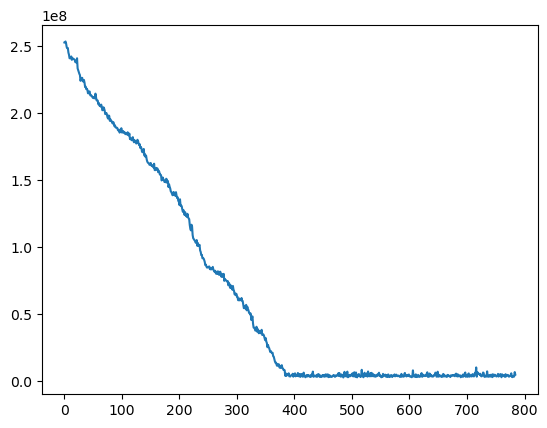

In [186]:
plt.plot(fit_list)

In [187]:
#alpha=0.9
problem = SetCoveringProblem(UNIVERSE_SIZE, NUM_SETS, SETS, COSTS)
best_solution, best_value,evaluations, fit_list,  = simulated_annealing(problem=problem,schedule=exponential_schedule())
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

C:\Users\user\AppData\Local\Temp\ipykernel_60456\1407305470.py:33: RuntimeWarning: overflow encountered in scalar divide
  probability = math.exp((current_value-neighbour_value) / temperature)


Best solution found has cost: 2518628.4076221646
Number of evaluations: 785


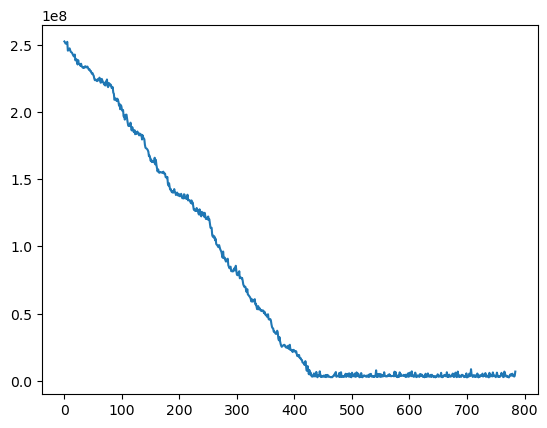

In [188]:
plt.plot(fit_list)

## Hill Climbing

I tried hill climbing to see if I would obtain better resolts

In [55]:
def hill_climbing(problem, max_iterations=1000):
    current_solution=problem.random_solution()
    current_value=problem.value(current_solution)
    iteration=0
    num_evaluations=1 
    costs=[current_value]
    while iteration<max_iterations and num_evaluations<10000:
        neighbour_solution=problem.neighbour(current_solution)
        neighbour_value = problem.value(neighbour_solution)
        num_evaluations += 1
        costs.append(neighbour_value)
        if neighbour_value<current_value:
            current_solution=neighbour_solution
            current_value=neighbour_value
            iteration=0
        else:
            iteration+=1
    return current_solution, current_value, num_evaluations, costs

In [56]:
problem = SetCoveringProblem(UNIVERSE_SIZE, NUM_SETS, SETS, COSTS)
best_solution, best_value,evaluations, fit_list,  = hill_climbing(problem)
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

Best solution found has cost: 2354173.0725127207
Number of evaluations: 1573


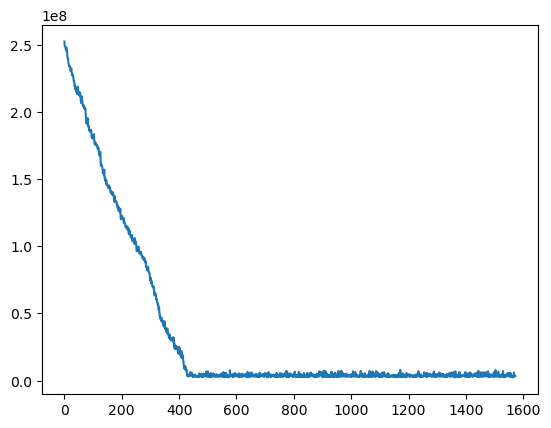

In [59]:
plt.plot(fit_list)

resolts are very similar, no improvment

To obtain a better result and avoid local minimal we could try other approach such as Genetic Algorithm. Or add heuritics to get out of local search or limitate the research space.

In [ ]:
problem = SetCoveringProblem(UNIVERSE_SIZE, NUM_SETS, SETS, COSTS)
best_solution, best_value,evaluations, fit_list,  = hill_climbing(problem, max_iterations=3000)
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

In [ ]:
plt.plot(fit_list)